In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Digital Signals
<!-- requirement: small_data/time_series_audio.wav -->
<!-- requirement: small_data/ambulance.wav -->

## Sampling

Regularly sampled signals are a special type of time series whose values are recorded at a regular interval of times. The time between two successive datapoints is called **sampling interval** (and its inverse is the **sampling frequency**).

"Signal Processing" is the set of techniques and tools that deal with such signals. While a in-depth treatment of signal processing would probably be outside the scope of this course, machine learning is increasingly applied to signal processing problems, especially concerning pattern recognition and signal classification and it is thus relevant to be viewed here.

Examples of sampled signals include:
- digital music recording
- physical sensor data
- atmospheric measurements

and in general any digitization of a physical phenomenon recorded at regular intervals.

Digital recording typically happens through a circuit called ADC or Analog to Digital Converter. This circuit converts the value of an analog voltage to an integer number in the interval $[0, 2^n-1]$, where $n$ is the number of bits available to the ADC.

The sampled signal is thus discrete both in the time variable (a multiple of the **sampling interval** $t_s$) and in the values themselves ($[0, 2^n-1]$).

Here are some examples of typical values for the **sampling interval** and **bit precision**:

| Physical phenomenon | sampling interval | sampling frequency | bit precision | signed? | min value | max value |
|---|--:|--:|--:|--:|--:|--:|
| Room temperature sensor | 60 s| 0.0166 Hz | 8 | TRUE | -128 | 127 |
| Phone line | 0.125 ms | 8 kHz | 8 | TRUE | -128 | 127 |
| Smartphone acceleration sensor | 20 ms | 50 Hz | 12 | TRUE | -2048 | 2047 |
| Heart Rate Sensor | 2 ms | 500 Hz | 16 | FALSE | 0 | 65535 |
| Music CD | 22.68 $\mu$s | 44.1 kHz | 16 | TRUE | -32768 | 32767 |
| Music DVD | 10.42 $\mu$s | 96 kHz | 24 | TRUE | -8388608 | 8388607 |



**Questions:**
1. What sampling frequency would you choose to record video? (Frame rate)
1. Why are digital signal used in telecommunications (like mobile phone network)

## Noise & Filters

When a physical phenomenon is converted to an analog voltage signal, noise is often picked up in the process. This could be due to environmental noise, transducer noise, elecrical noise or any other source of spurious fluctuations in the voltage that are not due to the signal we are recording.

When such signal is converted to a digital signal by means of an ADC, noise gets converted too. In addition, the process of discretization and the finite precision of the converter are an additional source of noise in the digital signal, called quantization noise.

When analyzing a digital signal it can be useful to pre-process the signal with a filter tuned to remove known sources of noise.

For example, if you are analyzing sound recorded by a microphone that was powered by standard AC current from a wall socket, it is possible that a low frequency (60Hz) fluctuation gets recorded together with the the sounds you are recording. This is nothing but the standard AC frequency of the electricity provider, and it should be removed with a filter.

Here is a glossary of terms you should be familiar with:

- [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency): half of the sampling rate of a discrete signal processing system.
- [FIR Filter: Finite Impulse Response Filter](https://en.wikipedia.org/wiki/Finite_impulse_response): a filter using only past values of the raw signal to calculate the current filtered sample.
- [IIR Filter: Infinite Impulse Response Filter](https://en.wikipedia.org/wiki/Infinite_impulse_response): a filter using past values of both the raw signal and the filtered signal to calculate the current filtered sample.
- Filter Order: the number of past points used to calculate a filter.

In this context, a 5-point moving average is a 5th order FIR filter with a flat kernel, while the exponentially weighted moving average is a simple case of a 1st order IIR filter.

In [ ]:
x = np.zeros(50)
x[10] = 1
plt.plot(x, '.-', label='Raw signal')
plt.plot(pd.Series(x).rolling(5).mean(), '.-', label='5 point moving average')
plt.plot(pd.Series(x).ewm(halflife=5).mean(), '.-', label='Exponential weighted moving average')
plt.legend()
plt.ylim(-0.1, 1.1)

## Audio files

There are several libraries to analyze sound files. One such library is [Librosa](https://github.com/librosa/librosa).

In [3]:
import librosa
import IPython.display

mono, fs = librosa.load('./small_data/time_series_audio.wav', sr = 44100)

In [4]:
# sampling frequency
fs

44100

In [5]:
mono[0:10]

array([ -7.62939453e-05,  -1.67846680e-04,  -2.44140625e-04,
        -2.44140625e-04,  -2.74658203e-04,  -3.96728516e-04,
        -4.73022461e-04,  -3.05175781e-04,  -1.06811523e-04,
         1.52587891e-05], dtype=float32)

In [6]:
mono.min()

-1.0

An audio file is loaded as a numpy array, the number of columns depending on the number of channels in the audio file (1 in the mono case). Notice that that the timestamp of each sample is implicitly defined by the sample index and the sampling frequency (44.1 kHz or 44100 samples per second).

In [ ]:
IPython.display.Audio(data=mono, rate=fs)

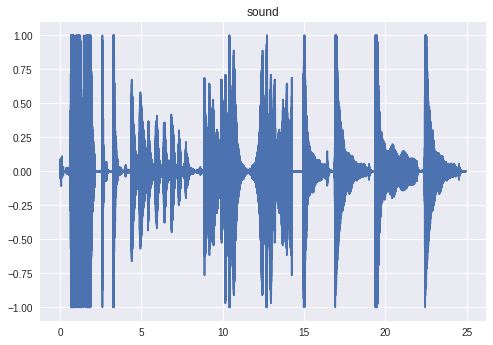

In [7]:
T = len(mono)/44100.0
t = np.linspace(0,T, len(mono)) # reconstructed timestamps

plt.plot(t,mono)
plt.title("sound")

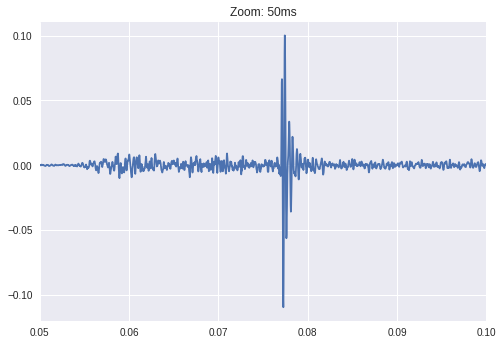

In [9]:
ts = pd.Series(mono[2205:4410], index = t[2205:4410])

ts.plot()
plt.title("Zoom: 50ms")

## Filters

Low pass filters remove noise in the high frequencies. Below 3 different low-pass filters are displayed.

The first 2 are the `rolling_mean` and the `ewma` that are explained in detail in the Time series Notebook, the third is a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter). The peculiarity of this filter is that it has as flat a frequency response as possible in the passband. For this reason it is also referred to as a "maximally flat magnitude filter".

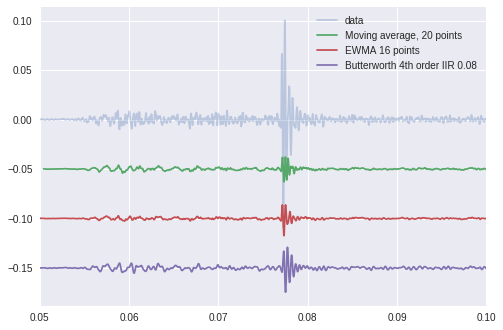

In [10]:
from scipy.signal import butter, lfilter

delta = 0.05

ax = pd.DataFrame(ts).plot(alpha = 0.3)
(pd.DataFrame(ts).rolling(20).mean() - delta).plot(alpha = 1.0, ax=ax)
(pd.Series(ts).ewm(16).mean() - 2*delta).plot(alpha = 1.0, ax=ax)
# Second argument to butter is the cut-off frequency, in units of the Nyquist frequency
pd.Series(data = lfilter(*butter(4, 0.08, 'low'), x = ts.values) - 3*delta,
          index = ts.index).plot(alpha = 1.0, ax=ax)
plt.legend(['data', 'Moving average, 20 points',
            'EWMA 16 points', 'Butterworth 4th order IIR 0.08'])

Let's apply a Butterworth IIR low-pass filter to our recorded sound. What's the effect?

In [11]:
filteredmono = lfilter(*butter(4, 0.08, 'low'), x = mono)
print "Cutoff: %f Hz" % (0.08 * 44100 / 2)
IPython.display.Audio(data=np.hstack([mono[0:44100*3], filteredmono[0:44100*3]]), rate=fs)

Cutoff: 1764.000000 Hz


**Questions:**

1. The examples above are Low-Pass filters. What do you think High-Pass and Band-Pass filters do?
1. What's the difference between an Infinite Impulse Response filter and a Finite Impulse Response filter?

## Frequency domain

Thus far we represented a digital signal as a time-series of samples recorded at regular intervals of time. This is called the **Time-Domain representation**. This representation is very useful when the information is contained in the absolute value of the signal itself.

For example, if we measure the outside temperature every hour, we may be interested in its value and/or in the trend (is it increasing/decreasing)?

In the case of a periodic phenomenon, we may also be interested to predict the re-occurrence of a pattern we observed already, i.e. we are interested in determining the frequency of a signal.

Furthermore, there are cases where the information is encoded in frequency and amplitude modulations of an oscillating signal. Sound and music are the typical example here. A note from an instrument is produced by the vibration of an actuator (string, air column, drum skin..) at a specific frequency. When we record it and analyze it, we are not only interested in the absolute values taken by the sound wave (pressure or volume), rather we are interested in the frequency of oscillation of such wave and in the variations of such frequency.

In order to easily capture that information, we need to represent a signal in term of its frequency content, and its variations over time. This is called a **Frequency-Domain representation**.

### Spectrograms
A [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time, and it is calculated as follows:

1. Choose a frame length: this is the window that will be used to calculate the Fourier transform and it determines the lowest frequencies that will be considered. 
1. Choose an overlap interval: this indicates the amount of overlap between two successive frames
1. For each frame calculate the FFT and take Log10(FFT^2)
1. Group the vectors in an 2D matrix where columns represent the successive frames while rows correspond to frequency bins.

**Questions:**
1. If we have a sound recorded at 44.1 kHz, and choose a frame length of 2048 samples, what's the lowest frequency available?
1. If you are going to record heartbeat with a pair of electrodes, which sampling frequency would you choose? Why?
1. What other precautions can be taken in order to minimize noise in a recording of a sound signal?

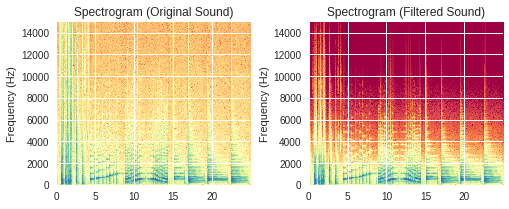

In [12]:
plt.figure(figsize=(8,3))
plt.subplots_adjust(wspace=0.3)
plt.subplot(121)
_, _, _, im = plt.specgram(mono, Fs=44100, NFFT=1024, cmap=plt.get_cmap('Spectral'))
plt.ylim(0,15000)
plt.title("Spectrogram (Original Sound)")
plt.ylabel("Frequency (Hz)")

plt.subplot(122)
_ = plt.specgram(filteredmono, Fs=44100, NFFT=1024, cmap=plt.get_cmap('Spectral'), 
                 vmin=im.get_clim()[0], vmax=im.get_clim()[1])
plt.ylim(0,15000)
plt.title("Spectrogram (Filtered Sound)")
plt.ylabel("Frequency (Hz)")

### Exercise

`plt.specgram` has several parameters that can be modified. Try changing one or more of the following and see what happens:

- NFFT
- noverlap
- detrend
- window
- pad_to

### Power spectral density

The [power spectral density](https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density) $P_{xx}$ of a signal is an estimate of the power in each frequency component.  It can be obtained by averaging the FFT obtained in several frames (Welch's method). The signal is divided into `NFFT` length segments.  Each segment is detrended by function `detrend` and windowed by function `window`. `noverlap` gives the length of the overlap between segments.  The $|\mathrm{fft}(i)|^2$ of each segment $i$ are averaged to compute $P_{xx}$, with a scaling to correct for power loss due to windowing.

The PSD of our original and filtered recordings is displayed below. Notice how the low-pass filter suppresses the higher frequencies.

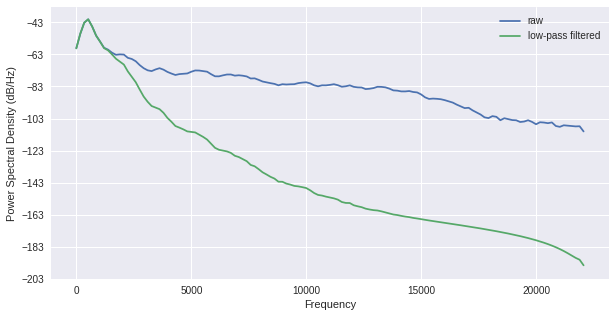

In [13]:
plt.figure(figsize = (10,5))
_ = plt.psd(mono, Fs = fs)
_ = plt.psd(filteredmono, Fs = fs)
plt.legend(['raw', 'low-pass filtered'])

### Mel-frequency scale

The [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a non-linear scale based on human perception of sound pitch. It is meant to be perceived by listeners to be equally spaced. It is obtained by the following transformation:

$$ m = 2595 \log_{10}{\left(1+\frac{f}{700}\right)} $$

In [ ]:
x = np.linspace(0,20000)
m = 2595 *np.log10(1+x/700.0)

plt.plot(x, m)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency (Mels)")

Let's look at the siren from an ambulance:

In [ ]:
mono, fs = librosa.load('./small_data/ambulance.wav', sr=44100)
IPython.display.Audio(data=mono, rate=fs)

In [ ]:
#plt.figure(figsize = (13,5))
_ = plt.specgram(mono, Fs = fs, NFFT=2048,
                 cmap=plt.get_cmap('Spectral'),
                 )
plt.colorbar(format='%+2.0f dB')
plt.ylim(0,15000)
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")

The spectrogram above was calculated with an FFT window of 2048 points, corresponding to roughly 46.5ms. This means that the lowest frequency we can analyze is ~21.5Hz, which corresponds to the lowest sound frequencies audible to the human ear.

We can distinguish a main frequency and 5+ harmonics.

Librosa allows to calculate and display the Mel-spectrogram:

In [ ]:
import librosa.display

f_min = librosa.midi_to_hz(24)
f_max = librosa.midi_to_hz(135)
S = librosa.feature.melspectrogram(y=mono, sr=fs, n_mels=128,fmax=f_max, fmin=f_min)
logS = librosa.logamplitude(S, ref_power=np.max) # calculate the log of the spectrum
librosa.display.specshow(logS,
                         y_axis='mel',
                         fmax=f_max,
                         fmin=f_min,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

### Mel Frequency Cepstrum

In sound processing, the [mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

In [ ]:
mfccs = librosa.feature.mfcc(S=librosa.logamplitude(S, ref_power=np.max), sr=fs)
librosa.display.specshow(mfccs,
                         x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Sliding windows feature extraction

Cross validation is not the only useful application of sliding windows&mdash;they are a very common way to extract features from a time series.  Let $\{x_i\}$ be the time series, where $x_i$ could be either a number or a vector. We can define a new time series $\{w^{(N)}_i\}$ whose elements are N-point windows of the original time series. A function $f$ can be applied to each window, produing a new times series we may use as a feature: $\{f(w^{(N)}_i)\}$.

An example of this is the rolling mean seen above. The framework is however much more powerful than a simple convolution with a flat kernel. For example we can calculate a non-linear function like min, max, var or median for each window and use that as a feature.

In [ ]:
fig, host = plt.subplots()
ts.plot(alpha=0.3)
pd.Series(ts).rolling(20).min().plot()
pd.Series(ts).rolling(20).max().plot()
plt.legend(['data','Rolling Min 20 pt', 'Rolling Max 20 pt'], loc=2)

child = host.twinx()
pd.Series(ts).rolling(20).var().plot(alpha=0.4, ax=child, c='k')
plt.legend(['Rolling Var 20 pt'], loc=4)

Features like rolling min and max are useful if we're interested in the envelope of a signal, while a feature like the rolling variance can be used to detect changes in the signal.

The spectrograms are also an example of a vectorial feature extracted from sliding windows: for each window of fixed length, the FFT coefficients are calculated and a new time series is obtained, whose elements are vectors of FFT coefficients.

This approach can be generalized to calculate the spectrogram for each sliding window, obtaining a time series of 2D matrices (images) as feature time-series. These features are successfully used as the starting point in speech recognition tasks, see for example the [Deep Speech paper](http://arxiv.org/pdf/1412.5567v2.pdf).


**Questions:**
1. In the last example where we used Spectrograms as features, how many time scale parameters are involved?

### Exit Tickets

1. What's the main characteristic of a sampled signal?
1. What is are low-pass, high-pass and band-pass filters? How can they be used?
1. What is a spectrogram? What are the parameters that influence its definition?
1. How can generalized features be extracted from a time series?


### Spoilers

### Answers:


**Intro:**
1. In order to give the impression of continuity, the sampling frequency for video needs to be faster than the [video frequency of the brain](https://www.quora.com/How-fast-does-the-brain-compute-visual-information-From-light-reach-the-eye-to-awareness-of-impression-And-how-does-the-information-travel), which is roughly 10Hz. Typical frame rates for video are 30-50Hz.
1. A digital signal is essentially a sequence of 0s and 1s. This can be encoded as two very different patterns in an analog radio wave. Once the wave travels through the air, it will be corrupted by noise (atmospheric noise, detector noise, interference etc.). However, if the pattern encoding the 1 is sufficiently different from the pattern encoding the 0, the detector can attempt to reconstruct the digital signal perfectly, removing all the noise due to transmission. This is not possible when the analog signal carries the information itself. An additional advantage of using digital signals is that they can be encrypted.


**Filters:**

1. The name says it
1. IIR filters use past values of both the raw signal and the filtered signal to calculate the current value of the filtered signal, while FIR only use past values of the raw signal.


**Spectrograms:**
1. 44100/2048 = 21.53 Hz.
1. A normal heart beats in a range of 30 - 210 Hz. In order to record this we need to make sure that the highest frequency we are interested is lower than the Nyquist frequency of our recording system. Since we want to record a signal with a max frequency of 210 Hz, we need to sample at at least twice that frequency, i.e. 420 Hz. Most commercial Heart Rate monitors record at 500 Hz.
1. Introduce a mechanical or electronic low-pass filter before the ADC so that noise is filtered out before the conversion to digital signal.

**Window Features:**
1. Four different time parameters are necessary:
    - the window length to calculate the spectrogram
    - the window overlap between consecutive spectrograms
    - the frame length to calculate the FFT inside a spectrogram window
    - the frame overlap between consecutive frames in the same spectrogram

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*